In [1]:
import torch, torchvision
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)


Torch: 2.5.1+cpu
Torchvision: 0.20.1+cpu


In [2]:
import PIL
print("Pillow:", PIL.__version__)

import matplotlib
print("Matplotlib:", matplotlib.__version__)


Pillow: 10.4.0
Matplotlib: 3.9.3


In [1]:
import torch
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torch.nn as nn
from torch import cat, no_grad, manual_seed 
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torchvision.models.segmentation as segmentation
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, 
                     MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn.functional as F

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Image Dimensions (256, 256)
im_width = 256
im_height = 256

# Path to the dataset
root = r"C:\Users\akhil\OneDrive\Desktop\Medical\Kvasir-SEG"
image_path = os.path.join(root, "images")
mask_path = os.path.join(root, "masks")
ids = next(os.walk(image_path))[2]
print(f"Total images: {len(ids)}")

Total images: 1000


In [4]:
class FootpathDataset(Dataset):
    def __init__(self, ids, image_dir, mask_dir, transform=None):
        self.ids = ids
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        id_ = self.ids[idx]
        image_path = os.path.join(self.image_dir, id_)
        mask_path = os.path.join(self.mask_dir, id_)

        # Load images and masks
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create dataset objects and split into train and validation sets
dataset = FootpathDataset(ids, image_path, mask_path, transform=transform)
train_size = int(0.8 * len(dataset)) # 80% train, 20% validation
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size]) 

# Create data loaders 
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size= batch_size, shuffle=False)

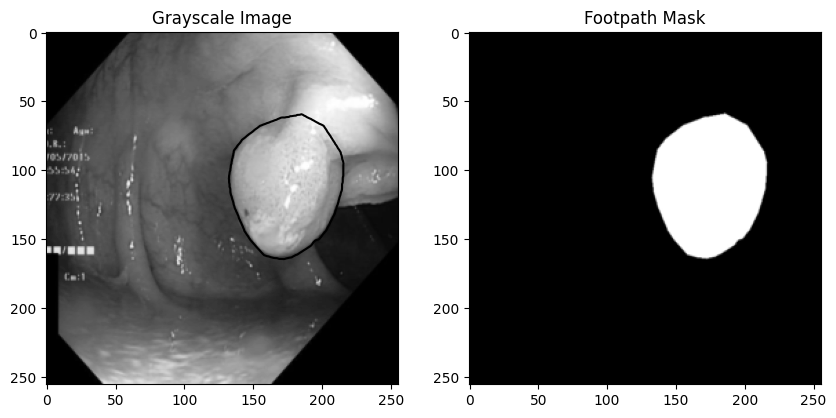

In [5]:
def visualize_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    # Convert tensor to numpy array and remove channel dimension (1) for visualization purposes 
    image_np = image.squeeze()
    mask_np = mask.squeeze()

    has_mask = mask_np.max() > 0

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    # Display the image and the mask
    ax1.imshow(image_np, cmap='gray')
    if has_mask:
        ax1.contour(mask_np, colors='k', levels=[0.5])
    ax1.set_title('Grayscale Image')

    ax2.imshow(mask_np, cmap='gray')
    ax2.set_title('Footpath Mask')

    plt.show()

# Visualize a random sample from the training set
visualize_sample(train_dataset)

In [6]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, batchnorm=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))
        self.conv1 = nn.Sequential(*layers)

        layers = [
            nn.Conv2d(out_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels))
        self.conv2 = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters=16, dropout=0.1, batchnorm=True):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.enc1 = ConvBlock(n_channels, n_filters, batchnorm=batchnorm)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(dropout)
        
        self.enc2 = ConvBlock(n_filters, n_filters * 2, batchnorm=batchnorm)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(dropout)

        self.enc3 = ConvBlock(n_filters * 2, n_filters * 4, batchnorm=batchnorm)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(dropout)

        self.enc4 = ConvBlock(n_filters * 4, n_filters * 8, batchnorm=batchnorm)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(dropout)

        # Bottleneck
        self.bottleneck = ConvBlock(n_filters * 8, n_filters * 16, batchnorm=batchnorm)

        # Expansive Path
        self.up6 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv6 = nn.Conv2d(n_filters * 16, n_filters * 8, kernel_size=3, padding=1)
        self.dec6 = ConvBlock(n_filters * 16, n_filters * 8, batchnorm=batchnorm)
        self.drop6 = nn.Dropout(dropout)

        self.up7 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv7 = nn.Conv2d(n_filters * 8, n_filters * 4, kernel_size=3, padding=1)
        self.dec7 = ConvBlock(n_filters * 8, n_filters * 4, batchnorm=batchnorm)
        self.drop7 = nn.Dropout(dropout)

        self.up8 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv8 = nn.Conv2d(n_filters * 4, n_filters * 2, kernel_size=3, padding=1)
        self.dec8 = ConvBlock(n_filters * 4, n_filters * 2, batchnorm=batchnorm)
        self.drop8 = nn.Dropout(dropout)

        self.up9 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv9 = nn.Conv2d(n_filters * 2, n_filters, kernel_size=3, padding=1)
        self.dec9 = ConvBlock(n_filters * 2, n_filters, batchnorm=batchnorm)
        self.drop9 = nn.Dropout(dropout)

        # Output
        self.outconv = nn.Conv2d(n_filters, n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        x1 = self.drop1(self.pool1(self.enc1(x)))
        x2 = self.drop2(self.pool2(self.enc2(x1)))
        x3 = self.drop3(self.pool3(self.enc3(x2)))
        x4 = self.drop4(self.pool4(self.enc4(x3)))

        # Bottleneck
        x5 = self.bottleneck(x4)

        # Expansive Path
        x6_up = self.up6(x5)
        x6_up = self.conv6(x6_up)
        x6 = torch.cat([x6_up, self.center_crop(x4, x6_up.size()[2:])], dim=1)
        x6 = self.drop6(self.dec6(x6))

        x7_up = self.up7(x6)
        x7_up = self.conv7(x7_up)
        x7 = torch.cat([x7_up, self.center_crop(x3, x7_up.size()[2:])], dim=1)
        x7 = self.drop7(self.dec7(x7))

        x8_up = self.up8(x7)
        x8_up = self.conv8(x8_up)
        x8 = torch.cat([x8_up, self.center_crop(x2, x8_up.size()[2:])], dim=1)
        x8 = self.drop8(self.dec8(x8))

        x9_up = self.up9(x8)
        x9_up = self.conv9(x9_up)
        x9 = torch.cat([x9_up, self.center_crop(x1, x9_up.size()[2:])], dim=1)
        x9 = self.drop9(self.dec9(x9))

        # Output
        output = self.outconv(x9)
        return output

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        if (layer_height, layer_width) == target_size:
            return layer
        else:
            resized_layer = F.interpolate(layer, size=target_size, mode='bilinear', align_corners=False)
            return resized_layer

# Example of creating a U-Net model
#model = UNet(n_channels=1, n_classes=1, n_filters=16, dropout=0.1, batchnorm=True)

In [9]:
# Initialize the model
model = UNet(n_channels=1, n_classes=1, n_filters=32, dropout=0.1, batchnorm=True).to(device)

# Define the loss function and optimizer
# For binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/40], Train Loss: 0.4822, Accuracy: 0.8043, IoU: 0.3672, Dice: 0.3828, Val Loss: 0.4378, Val Accuracy: 0.8288, Val IoU: 0.5830, Val Dice: 0.5830
Validation Loss Decreased(inf--->0.437763) 	 Saving The Model
Epoch [2/40], Train Loss: 0.3918, Accuracy: 0.8384, IoU: 0.5904, Dice: 0.5907, Val Loss: 0.4001, Val Accuracy: 0.8288, Val IoU: 0.5831, Val Dice: 0.5831
Validation Loss Decreased(0.437763--->0.400089) 	 Saving The Model
Epoch [3/40], Train Loss: 0.3534, Accuracy: 0.8395, IoU: 0.5847, Dice: 0.5880, Val Loss: 0.3991, Val Accuracy: 0.8005, Val IoU: 0.5075, Val Dice: 0.5429
Validation Loss Decreased(0.400089--->0.399081) 	 Saving The Model
Epoch [4/40], Train Loss: 0.3307, Accuracy: 0.8467, IoU: 0.5625, Dice: 0.5905, Val Loss: 0.3368, Val Accuracy: 0.8457, Val IoU: 0.6010, Val Dice: 0.6232
Validation Loss Decreased(0.399081--->0.336816) 	 Saving The Model
Epoch [5/40], Train Loss: 0.3212, Accuracy: 0.8526, IoU: 0.5804, Dice: 0.6098, Val Loss: 0.3606, Val Accuracy: 0.8288, Val Io

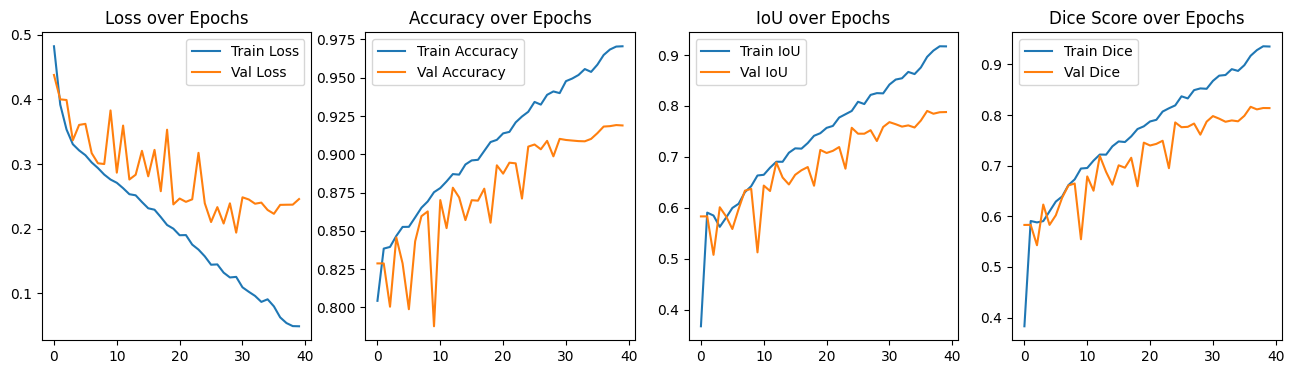

In [11]:
def calculate_iou(preds, labels, smooth=1e-6):
    preds = torch.sigmoid(preds) > 0.5
    labels = labels > 0.5
    intersection = (preds & labels).float().sum((1, 2))
    union = (preds | labels).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def calculate_accuracy(preds, labels):
    preds = torch.sigmoid(preds) > 0.5
    correct = (preds == labels).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy

def calculate_dice(preds, labels, smooth=1e-6):
    preds = torch.sigmoid(preds) > 0.5
    labels = labels > 0.5
    intersection = (preds & labels).float().sum((1, 2))
    dice = (2. * intersection + smooth) / (preds.float().sum((1, 2)) + labels.float().sum((1, 2)) + smooth)
    return dice.mean()

num_epochs = 40
best_val_loss = float('inf')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_ious = []
val_ious = []
train_dices = []
val_dices = []

# ReduceLROnPlateau scheduler 
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=0.000001)

for epoch in range(num_epochs):
    model.train()
    train_loss, train_accuracy, train_iou, train_dice = 0, 0, 0, 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, masks).item()
        train_iou += calculate_iou(outputs, masks).item()
        train_dice += calculate_dice(outputs, masks).item()

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)
    train_iou /= len(train_loader)
    train_dice /= len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_ious.append(train_iou)
    train_dices.append(train_dice)

    model.eval()
    val_loss, val_accuracy, val_iou, val_dice = 0, 0, 0, 0
    with torch.no_grad():
        for images, masks in valid_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            val_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, masks).item()
            val_iou += calculate_iou(outputs, masks).item()
            val_dice += calculate_dice(outputs, masks).item()

    val_loss /= len(valid_loader)
    val_accuracy /= len(valid_loader)
    val_iou /= len(valid_loader)
    val_dice /= len(valid_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_ious.append(val_iou)
    val_dices.append(val_dice)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, IoU: {train_iou:.4f}, Dice: {train_dice:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        print(f"Validation Loss Decreased({best_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model")
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'footpath_segmentation_model.pth')

# Plot Metrics
plt.figure(figsize=(16, 4))
plt.subplot(1, 4, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 4, 3)
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.title('IoU over Epochs')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(train_dices, label='Train Dice')
plt.plot(val_dices, label='Val Dice')
plt.title('Dice Score over Epochs')
plt.legend()

plt.show()

In [12]:
model_path = 'footpath_segmentation_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

C:\Users\akhil\AppData\Local\Temp\ipykernel_21900\1192481190.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


UNet(
  (enc1): ConvBlock(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (enc2): ConvBlock(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e

In [15]:
def plot_sample(image, mask, pred, binary_pred, ax):
    has_mask = mask.max() > 0

    ax[0].imshow(image.squeeze(), cmap='gray')
    if has_mask:
        ax[0].contour(mask.squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Grayscale Image')

    ax[1].imshow(mask.squeeze(), cmap='gray')
    ax[1].set_title(' Mask')

    ax[2].imshow(pred.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(mask.squeeze(), colors='k', levels=[0.5])
    ax[2].set_title(' Predicted')
    
    ax[3].imshow(binary_pred.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(mask.squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary')

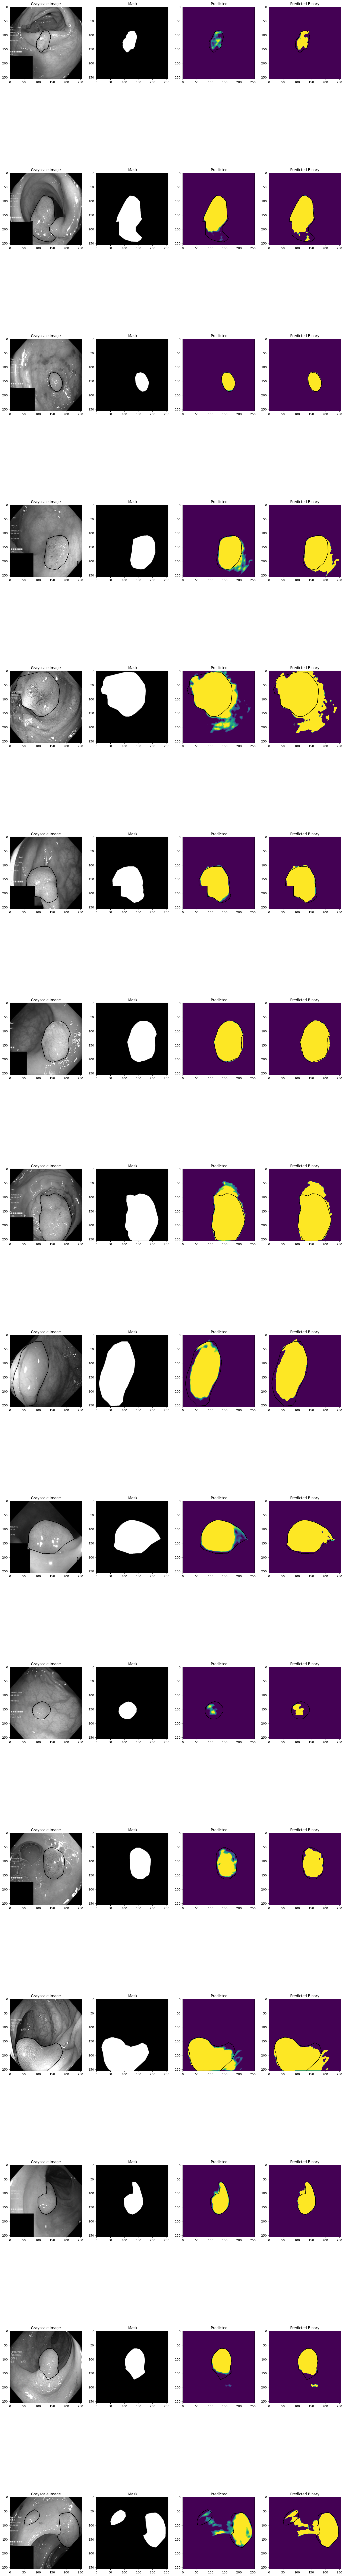

In [16]:
# Get a batch of data from the DataLoader
images, masks = next(iter(train_loader)) 

# Make predictions for this batch
model.eval()
with torch.no_grad():
    preds = model(images.to(device))
    preds_t = (torch.sigmoid(preds) > 0.5).type(torch.uint8)  # Binary predictions

# Convert tensors to CPU for visualization
images, masks, preds, preds_t = images.cpu(), masks.cpu(), preds.cpu(), preds_t.cpu()

# Plot a few samples
fig, axes = plt.subplots(nrows=len(images), ncols=4, figsize=(20, 10 * len(images)))
for i in range(len(images)):
    plot_sample(images[i], masks[i], preds[i], preds_t[i], axes[i])
plt.show()